In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import requests

In [4]:
# Function to return the potential payout using the odds and amount wagered.
def calculate_payout(odds_str, amount_bet):
    try:
        odds = float(odds_str)
        if odds >= 100:
            payout = amount_bet * (odds / 100)
            return round(payout, 2)
        else:
            payout = amount_bet / (abs(odds) / 100)
            return round(payout, 2)
    except ValueError:
        return "Invalid odds format. Please enter a valid number."

In [5]:
def calculate_bet_amount(odds_str, desired_return):
    try:
        odds = float(odds_str)
        if odds >= 100:
            bet_amount = desired_return / (odds / 100)
            return round(bet_amount, 2)
        else:
            bet_amount = desired_return * (abs(odds) / 100)
            return round(bet_amount, 2)
    except ValueError:
        return "Invalid odds format. Please enter a valid number."

In [6]:
def calculate_best_hedge(bonus, both_lines):
    distances = []
    distance_hedge = []
    min_payout = []
    
    for hedge in range(bonus * 4):
        possible_payouts = (calculate_payout(both_lines[0], bonus) - hedge,
                            calculate_payout(both_lines[1], hedge),
                            calculate_payout(both_lines[1], bonus) - hedge,
                            calculate_payout(both_lines[0], hedge))

        min1 = min(possible_payouts[0], possible_payouts[1])
        min2 = min(possible_payouts[2], possible_payouts[3])

        bonus_on_first = "first" if min1 > min2 else "second"

        higher_min = max(min1, min2)
        min_payout.append((hedge, higher_min, bonus_on_first))

    max_tuple = max(min_payout, key=lambda x: x[1])

    str = f"You should put the bonus on {bonus_on_first} and hedge with ${max_tuple[0]}. Your minimum payout will be ${max_tuple[1]}."
    
    return max_tuple, min_payout, str

(2803, 596.38, 'first')
You should put the bonus on first and hedge with $2803. Your minimum payout will be $596.38.


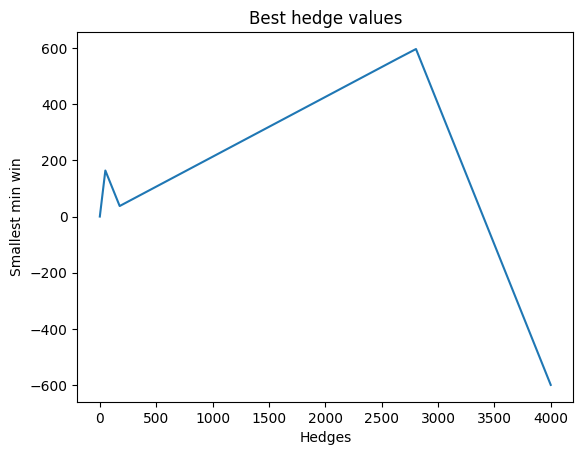

In [14]:
bonus = 1000
both_lines = (+340,-470)

# Returns [(x, y)]
best_hedge, graph_of_hedges, str = calculate_best_hedge(bonus, both_lines)
print(best_hedge)
print(str)

hedges = [x[0] for x in graph_of_hedges]
smallest_dist = [y[1] for y in graph_of_hedges]

 
# plotting the points 
plt.plot(hedges, smallest_dist)
 
# naming the x axis
plt.xlabel('Hedges')
# naming the y axis
plt.ylabel('Smallest min win')
 
# giving a title to my graph
plt.title('Best hedge values')
 
# function to show the plot
plt.show()

In [7]:
def calculate_best_hedge_from_api(bonus, both_lines):
    should_hedge = 0
    least_payout = 0
    bonus_on = "none"
    
    for hedge in range(bonus * 4):
        possible_payouts = (calculate_payout(both_lines[0], bonus) - hedge,
                            calculate_payout(both_lines[1], hedge),
                            calculate_payout(both_lines[1], bonus) - hedge,
                            calculate_payout(both_lines[0], hedge))

        min1 = min(possible_payouts[0], possible_payouts[1])
        min2 = min(possible_payouts[2], possible_payouts[3])
        higher_min = max(min1, min2)

        if higher_min > least_payout:
            least_payout = higher_min
            should_hedge = hedge
            bonus_on = both_lines[0] if min1 > min2 else both_lines[1]

    str = f"You should put the bonus on {bonus_on} and hedge with ${should_hedge}. Your minimum payout will be ${least_payout}."

    return should_hedge, least_payout, bonus_on

In [12]:
bonus = 1000
both_lines = (+340,-470)
should_hedge, least_payout, bonus_on = calculate_best_hedge_from_api(bonus, both_lines)
print(f"Hedge with: {should_hedge}")
print(f"Bonus on: {bonus_on}")
print(f"Least Payout: {least_payout}")

Hedge with: 2803
Bonus on: 340
Least Payout: 596.38


In [10]:
f = open('odds_data.json')
data = json.load(f)

bonus = 5000
end_hedge = 0
end_bonus_side = 0
current_best_bet_winnings = 0

current_best_bet = data[0]['bookmakers'][0]['markets'][1]['outcomes']

# Iterate through all of the Matchups
for matchups in range(len(data)):
    for books in range(len(data[matchups]['bookmakers'])):
        if data[matchups]['bookmakers'][books]['key'] == "draftkings" or data[matchups]['bookmakers'][books]['key'] == "fanduel":
            for bet_type in range(len(data[matchups]['bookmakers'][books]['markets'])):

                # Getting Line From Bet
                lines = (data[matchups]['bookmakers'][books]['markets'][bet_type]['outcomes'][0]['price'], data[matchups]['bookmakers'][books]['markets'][bet_type]['outcomes'][1]['price'])
                should_hedge, least_payout, bonus_on = calculate_best_hedge_from_api(bonus, lines)

                if least_payout > current_best_bet_winnings:
                    current_best_bet_winning = least_payout
                    current_best_bet = data[matchups]['bookmakers'][books]['markets'][bet_type]['outcomes']
                    end_hedge = should_hedge
                    current_best_bet_winnings = least_payout
                    end_bonus_side = bonus_on
                    

print(f"Hedge with: {end_hedge}")
print(f"Bonus on: {end_bonus_side}")
print(f"Least Payout: {current_best_bet_winnings}")
print(current_best_bet)

Hedge with: 14318
Bonus on: 350
Least Payout: 3181.78
[{'name': 'New York Knicks', 'price': -450}, {'name': 'San Antonio Spurs', 'price': 350}]


In [8]:
API_KEY = ''

SPORT = 'basketball_nba' # use the sport_key from the /sports endpoint below, or use 'upcoming' to see the next 8 games across all sports

REGIONS = 'us' # uk | us | eu | au. Multiple can be specified if comma delimited

MARKETS = 'h2h,spreads' # h2h | spreads | totals. Multiple can be specified if comma delimited

ODDS_FORMAT = 'american' # decimal | american

DATE_FORMAT = 'iso' # iso | unix

odds_response = requests.get(
    f'https://api.the-odds-api.com/v4/sports/{SPORT}/odds',
    params={
        'api_key': API_KEY,
        'regions': REGIONS,
        'markets': MARKETS,
        'oddsFormat': ODDS_FORMAT,
        'dateFormat': DATE_FORMAT,
    }
)

if odds_response.status_code != 200:
    print(f'Failed to get odds: status_code {odds_response.status_code}, response body {odds_response.text}')

else:
    odds_json = odds_response.json()

    # Specify the file path where you want to save the JSON data
    file_path = 'odds_data.json'

    # Write the JSON data to the file
    with open(file_path, 'w') as json_file:
        json.dump(odds_json, json_file)

    print(f'JSON data has been successfully written to {file_path}')

JSON data has been successfully written to odds_data.json
